### Load the data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
df_train=pd.read_csv("training_data.csv")
text_train=df_train['text']

In [3]:
star_train=df_train.stars

In [4]:
df_test=pd.read_csv("test_data.csv")
text_test=df_test.text

In [5]:
df_sub=pd.read_csv("sample_submission.csv",names=np.array(['id','stars']))
star_test=df_sub.stars

In [6]:
df_train.head()

,review_id,business_id,user_id,text,date,stars
0,3223,2055,2533,"Sometimes things happen, and when they do this...",2010-12-30,5
1,9938,4165,6371,I know Kerrie through my networking and we ben...,2011-04-26,5
2,7123,869,4929,Love their pizza!!!\nVery fresh. Their cannoli...,2012-09-28,5
3,3601,1603,2789,Being from NJ I am always on the prowl for my ...,2009-06-07,4
4,3948,2347,1245,We have tried this spot a few times and each v...,2011-02-20,4


In [60]:
print(df_train.review_id.shape,df_train.review_id.unique().shape )
print(df_train.user_id.shape,df_train.user_id.unique().shape )
print(df_train.business_id.shape,df_train.business_id.unique().shape)

(7997,) (7997,)
(7997,) (5400,)
(7997,) (3637,)


Text(0.5,1,'business_id v.s stars')

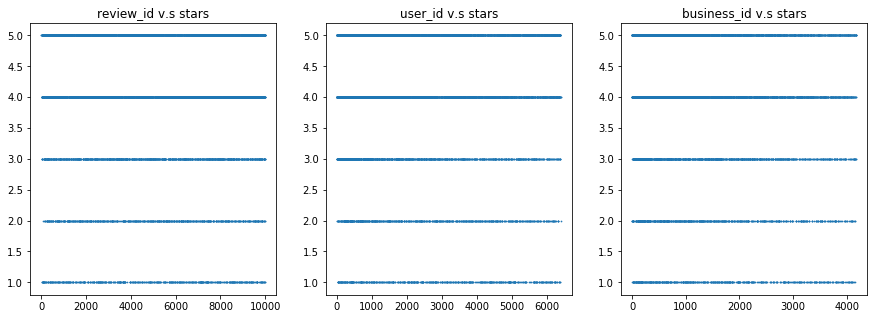

In [66]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(df_train.review_id,df_train.stars,s=0.5)
plt.title('review_id v.s stars')
plt.subplot(1,3,2)
plt.scatter(df_train.user_id,df_train.stars,s=0.5)
plt.title('user_id v.s stars')
plt.subplot(1,3,3)
plt.scatter(df_train.business_id,df_train.stars,s=0.5)
plt.title('business_id v.s stars')

Text(0.5,1,'business_id v.s stars')

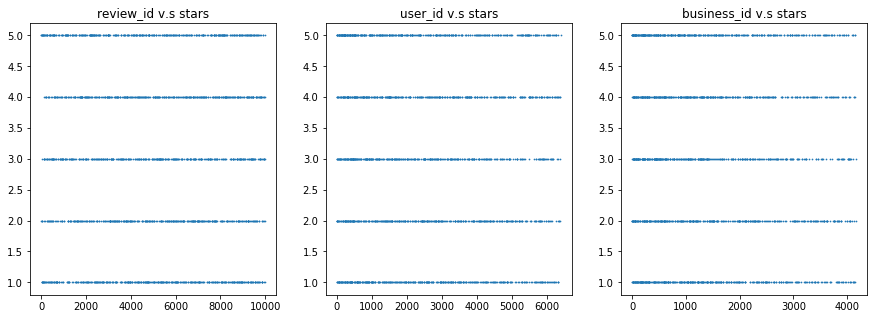

In [63]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.scatter(df_test.review_id,df_sub.stars,s=0.5)
plt.title('review_id v.s stars')
plt.subplot(1,3,2)
plt.scatter(df_test.user_id,df_sub.stars,s=0.5)
plt.title('user_id v.s stars')
plt.subplot(1,3,3)
plt.scatter(df_test.business_id,df_sub.stars,s=0.5)
plt.title('business_id v.s stars')

### Text processing

#### tf-idf (ngram_range=(1, 1)

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
tfidf=TfidfVectorizer(ngram_range=(1, 1),stop_words='english')
tfidf.fit(text_train)
td_train=tfidf.transform(text_train)
td_test=tfidf.transform(text_test)

In [9]:
td_train=td_train.toarray()
td_test=td_test.toarray()

In [35]:
text_45=np.zeros((len(td_train[0])))
for i in range(len(star_train)):
    if (star_train[i]==4)|(star_train[i]==5):
        for j in range(len(td_train[i])):
            text_45[j]+=td_train[i][j]
text_45

array([9.42690061, 1.29433426, 0.161063  , ..., 0.16700122, 0.05257418,
       0.07517265])

In [37]:
text_12=np.zeros((len(td_train[0])))
for i in range(len(star_train)):
    if (star_train[i]==1)|(star_train[i]==2):
        for j in range(len(td_train[i])):
            text_12[j]+=td_train[i][j]
text_12

array([5.9050242 , 0.53625485, 0.        , ..., 0.        , 0.        ,
       0.        ])

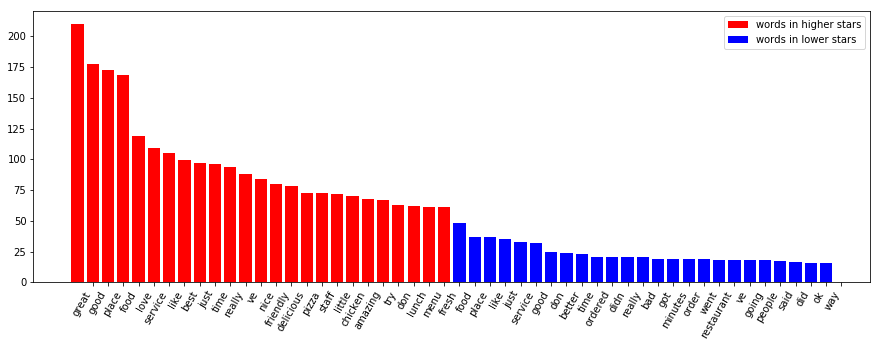

In [70]:
ind_45=np.argsort(-text_45)[:25]
ind_12=np.argsort(-text_12)[:25]
ind=np.hstack([ind_45,ind_12])
text=np.hstack([text_45[ind_45],text_12[ind_12]])
plt.figure(figsize=(15,5))
plt.bar(np.arange(25), text_45[ind_45], color='red',label='words in higher stars')
plt.bar(range(25,50), text_12[ind_12], color='blue',label='words in lower stars')
feature_names = np.array(tfidf.get_feature_names())
plt.xticks(np.arange(1, 51), feature_names[ind], rotation=60, ha="right");
plt.legend()

we can find that in lower stars (1,2), the most important words seems not really 'bad'.
however, we know that good words and bad words in the text can somehow affect the star value, so we should figure out another way to point out this situation.

#### sentiment-analysis

reference:https://github.com/shekhargulati/sentiment-analysis-python/blob/master/opinion-lexicon-English/negative-words.txt

In [9]:
positive_words=pd.read_csv("positive-words.txt")
negative_words=pd.read_csv("negative-words.txt")

In [12]:
train_pos=np.zeros((len(td_train),1))
train_neg=np.zeros((len(td_train),1))
test_pos=np.zeros((len(td_test),1))
test_neg=np.zeros((len(td_test),1))

for i in range(len(td_train)):
    n=0
    for word in tfidf.get_feature_names():
        for pos in positive_words:
            if word==pos:
                n+=1
                break
    train_pos[i]=n

for i in range(len(td_train)):
    n=0
    for word in tfidf.get_feature_names():
        for neg in negative_words:
            if word==neg:
                n+=1
                break
    train_neg[i]=n
    
for i in range(len(td_test)):
    n=0
    for word in tfidf.get_feature_names():
        for p in positive_words:
            if word==p:
                n+=1
                break
    test_pos[i]=n  
    
for i in range(len(td_test)):
    n=0
    for word in tfidf.get_feature_names():
        for neg in negative_words:
            if word==neg:
                n+=1
                break
    train_neg[i]=n

#### #weight of negative-word=-1, weight od positive word=1

In [138]:
""""
Wneg=np.zeros((td_train.shape[1]))
for i in range(len(tfidf.get_feature_names())):
    word=tfidf.get_feature_names()[i]
    for j in np.array(negative_words):
        if word==j:
            Wneg[i]=-1  
"""

In [144]:
#W_td_train=np.multiply(td_train,Wneg)

In [145]:
#W_td_test=np.multiply(td_test,Wneg)

### Extracting features

In [13]:
train_business_id=np.array(df_train.business_id)
train_business_id=train_business_id[:,np.newaxis]

train_user_id=np.array(df_train.user_id)
train_user_id=train_user_id[:,np.newaxis]

test_business_id=np.array(df_test.business_id)
test_business_id=test_business_id[:,np.newaxis]

test_user_id=np.array(df_test.user_id)
test_user_id=test_user_id[:,np.newaxis]

#### PCA

In [14]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

In [15]:
#reduce text dimension 
pca.fit(td_train)
td_pca_train=pca.transform(td_train)
td_pca_test=pca.transform(td_test)

In [16]:
#combine all the features
train_feature=np.concatenate((td_pca_train,train_business_id,train_user_id,train_pos,train_neg),axis=1)
test_feature=np.concatenate((td_pca_test,test_user_id,test_business_id,test_pos,test_neg),axis=1)

In [17]:
#extract features
pca.fit(train_feature)
train=pca.transform(train_feature)
test=pca.transform(test_feature)

### Rating predict

### Create the text similarity matrix for collaborative filtering

#### by cosine similarity measure

In [18]:
from sklearn.metrics.pairwise import linear_kernel

In [19]:
cos_sim=linear_kernel(test,train)

In [20]:
cos_sim.shape

(2003, 7997)

#### collaborative filtering: Rtest,text=sum(cos_sim[test,train]* Rtrain,text)/sum(cos_sim[test,train]

In [21]:
star_pred_CF=np.zeros((len(df_test)))

In [22]:
upper=0
lower=0

for i in range(len(df_test)):
    sim=cos_sim[i]
    sort_ind_sim=np.argsort(-sim)[:99]
    sort_sim=np.sort(sim)[:-100:-1]
    upper=sum(sort_sim*star_train[sort_ind_sim])
    lower=sum(sort_sim)

    if lower!=0:
        R=upper/lower
        if R<0:
            R=0
        if R>5:
            R=5
        star_pred_CF[i]=(upper/lower)

In [23]:
import sklearn.metrics #inclusding the module of Rooted Mean Square Error(rmse)
import math

rmse=math.sqrt(sklearn.metrics.mean_squared_error(star_test, star_pred_CF))
rmse

1.628228706957193

In [39]:
star_pred_CF_=np.zeros((len(df_test)))
upper=0
lower=0

for i in range(len(df_test)):
    sim=cos_sim[i]
    sort_ind_sim=np.argsort(-sim)[:199]
    sort_sim=np.sort(sim)[:-200:-1]
    upper=sum(sort_sim*star_train[sort_ind_sim])
    lower=sum(sort_sim)

    if lower!=0:
        R=upper/lower
        if R<0:
            R=0
        if R>5:
            R=5
        star_pred_CF_[i]=(upper/lower)
        
rmse_=math.sqrt(sklearn.metrics.mean_squared_error(star_test, star_pred_CF_))
rmse_

1.6142244833228407

In [41]:
star_pred_CF_=np.zeros((len(df_test)))
upper=0
lower=0

number=[199,299,399,499,599,699,799,899,999]
for n in number:
    for i in range(len(df_test)):
        sim=cos_sim[i]
        sort_ind_sim=np.argsort(-sim)[:n]
        sort_sim=np.sort(sim)[:-(n+1):-1]
        upper=sum(sort_sim*star_train[sort_ind_sim])
        lower=sum(sort_sim)
        if lower!=0:
            R=upper/lower
            if R<0:
                R=0
            if R>5:
                R=5
            star_pred_CF_[i]=(upper/lower)
    rmse_=math.sqrt(sklearn.metrics.mean_squared_error(star_test, star_pred_CF_))
    print(rmse_)

1.6142244833228407
1.6065856221080492
1.602472615601169
1.5981503766902745
1.5937872892916385
1.5913218579400938
1.5909317122236832
1.590736591442333
1.5918543068364308


In [42]:
star_pred_CF_=np.zeros((len(df_test)))
upper=0
lower=0

number=[1099,1199,1299,1399,1499,1599,1699,1799,1899,1999]
for n in number:
    for i in range(len(df_test)):
        sim=cos_sim[i]
        sort_ind_sim=np.argsort(-sim)[:n]
        sort_sim=np.sort(sim)[:-(n+1):-1]
        upper=sum(sort_sim*star_train[sort_ind_sim])
        lower=sum(sort_sim)
        if lower!=0:
            R=upper/lower
            if R<0:
                R=0
            if R>5:
                R=5
            star_pred_CF_[i]=(upper/lower)
    rmse_=math.sqrt(sklearn.metrics.mean_squared_error(star_test, star_pred_CF_))
    print(rmse_)

1.5926644397423213
1.5931154008469415
1.5935175491521254
1.5944362769211218
1.5949558714910215
1.595453302414343
1.596110128907924
1.59670565437704
1.5975280978570614
1.597680205073665


In [73]:
star_pred_CF_=np.zeros((len(df_test)))
upper=0
lower=0

for i in range(len(df_test)):
    sim=cos_sim[i]
    sort_ind_sim=np.argsort(-sim)[:899]
    sort_sim=np.sort(sim)[:-900:-1]
    upper=sum(sort_sim*star_train[sort_ind_sim])
    lower=sum(sort_sim)

    if lower!=0:
        R=upper/lower
        if R<0:
            R=0
        if R>5:
            R=5
        star_pred_CF_[i]=(upper/lower)
        
rmse_=math.sqrt(sklearn.metrics.mean_squared_error(star_test, star_pred_CF_))
rmse_

1.590736591442333

#### Linear regression

In [67]:
from sklearn.linear_model import LinearRegression
LR=LinearRegression()

LR.fit(train,star_train)
star_pred_LR=LR.predict(test)
#print('score:',LR.score(test,star_test))

import sklearn.metrics #inclusding the module of Rooted Mean Square Error(rmse)
import math
rmse=math.sqrt(sklearn.metrics.mean_squared_error(star_test, star_pred_LR))
print('rmse:',rmse)

rmse: 1.581057995543768


#### KNeighborsRegressor

In [25]:
from sklearn.neighbors import KNeighborsRegressor

n_neighbors=[1,3,5,10,20,50]

for n in n_neighbors:
    knr=KNeighborsRegressor(n_neighbors=n)
    knr.fit(train,star_train)
    print(n,knr.score(test,star_test))

1 -0.8079953753933811
3 -0.4262506917717668
5 -0.33197508309764134
10 -0.292803066486373
20 -0.25816442005839324
50 -0.22198161760168644


In [74]:
KNR=KNeighborsRegressor(n_neighbors=50)
KNR.fit(train,star_train)
star_pred_KNR=KNR.predict(test)

#print('score:',KNR.score(test,star_test))

rmse=math.sqrt(sklearn.metrics.mean_squared_error(star_test, star_pred_KNR))
print('rmse:',rmse)

rmse: 1.5834955045659362


In [27]:
for n in n_neighbors:
    knr=KNeighborsRegressor(n_neighbors=n)
    knr.fit(td_train,star_train)
    print(n,knr.score(td_test,star_test))

1 -0.2525313137565772
3 -0.2584517220642846
5 -0.3308364182669534
10 -0.36445866035087393
20 -0.3674075102970138
50 -0.3579258385196984


#### svm (classifier)

In [28]:
from sklearn import svm
clf=svm.SVC() #default: kernel='rbf'
clf.fit(train,star_train)
star_pred_svm=clf.predict(test)
print('score:',clf.score(test,star_test))
rmse=math.sqrt(sklearn.metrics.mean_squared_error(star_test, star_pred_svm))
print('rmse:',rmse)

score: 0.2076884672990514
rmse: 1.7375187891605577


#### svr (regression)

In [31]:
#splitting the data simply into three parts, training, validation and testing because training set is very large
from sklearn.model_selection import train_test_split, ShuffleSplit
X_train, X_test, y_train, y_test = train_test_split(train, star_train, random_state=1)

In [32]:
#find the best C and gamma in an SVM
from sklearn.svm import SVR
#from sklearn.model_selection import KFold
#cv=KFold(shuffle=True)
single_split_cv = ShuffleSplit(n_splits=1)

from sklearn.model_selection import GridSearchCV
param_grid={'C':[0.001,0.01,0.1,1,10],'gamma':[0.001,0.01,0.1,1]}

grid=GridSearchCV(SVR(),param_grid=param_grid,cv=single_split_cv,verbose=3)
grid.fit(X_train,y_train)

Fitting 1 folds for each of 20 candidates, totalling 20 fits
[CV] C=0.001, gamma=0.001 ............................................
[CV] .. C=0.001, gamma=0.001, score=-0.0731570787739082, total=   2.2s
[CV] C=0.001, gamma=0.01 .............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s remaining:    0.0s


[CV] .. C=0.001, gamma=0.01, score=-0.07345020873615282, total=   2.2s
[CV] C=0.001, gamma=0.1 ..............................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    7.6s remaining:    0.0s


[CV] ... C=0.001, gamma=0.1, score=-0.07363097950452269, total=   2.3s
[CV] C=0.001, gamma=1 ................................................
[CV] ..... C=0.001, gamma=1, score=-0.07362999731893871, total=   2.2s
[CV] C=0.01, gamma=0.001 .............................................
[CV] ... C=0.01, gamma=0.001, score=-0.0706683710734266, total=   2.3s
[CV] C=0.01, gamma=0.01 ..............................................
[CV] ... C=0.01, gamma=0.01, score=-0.07318649579304239, total=   2.3s
[CV] C=0.01, gamma=0.1 ...............................................
[CV] .... C=0.01, gamma=0.1, score=-0.07368589850182561, total=   2.7s
[CV] C=0.01, gamma=1 .................................................
[CV] ...... C=0.01, gamma=1, score=-0.07383704731365737, total=   3.2s
[CV] C=0.1, gamma=0.001 ..............................................
[CV] ... C=0.1, gamma=0.001, score=-0.06251025256130549, total=   2.4s
[CV] C=0.1, gamma=0.01 ...............................................
[CV] .

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed:  1.7min finished


GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=None, test_size='default',
       train_size=None),
       error_score='raise',
       estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': [0.001, 0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [33]:
print(grid.best_score_)
print(grid.best_params_)

-0.008250254089764875
{'C': 10, 'gamma': 1}


In [68]:
svr=SVR(gamma=1,C=10,epsilon=0.2)
svr.fit(train,star_train)
star_pred_svr=svr.predict(test)
#print(svr.score(test,star_test))
rmse=math.sqrt(sklearn.metrics.mean_squared_error(star_test, star_pred_svr))
print('rmse:',rmse)

rmse: 1.5870829580447416


#### DecisionTreeClassifier

In [35]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(train, star_train)
dtc.score(test, star_test)

0.19021467798302547

In [37]:
star_pred_dtc=dtc.predict(test)
star_pred_dtc

array([1, 5, 5, ..., 4, 4, 3], dtype=int64)

### Visualize the text data

#### predicted rating v.s true rating

In [44]:
color={1:'y',2:'g',3:'b',4:'r',5:'k'}
df_train['color']=df_train['stars'].map(color)
df_train.head()

,review_id,business_id,user_id,text,date,stars,color
0,3223,2055,2533,"Sometimes things happen, and when they do this...",2010-12-30,5,k
1,9938,4165,6371,I know Kerrie through my networking and we ben...,2011-04-26,5,k
2,7123,869,4929,Love their pizza!!!\nVery fresh. Their cannoli...,2012-09-28,5,k
3,3601,1603,2789,Being from NJ I am always on the prowl for my ...,2009-06-07,4,r
4,3948,2347,1245,We have tried this spot a few times and each v...,2011-02-20,4,r


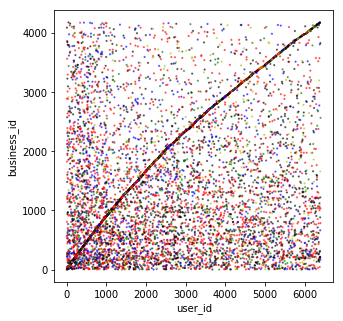

In [45]:
df_train.plot.scatter(x='user_id',y='business_id',c=df_train['color'],s=1.5,figsize=(5,5),alpha=0.5)
plt.xlabel='user_id'
plt.ylabel='business_id'

In [80]:
df_sub['user_id']=df_test.user_id
df_sub['business_id']=df_test.business_id
df_sub.head()

,id,stars,user_id,business_id
0,2713,1,2196,668
1,4734,1,3521,1014
2,5598,5,3028,2939
3,9545,1,6200,4077
4,1471,4,1268,1126


In [86]:
df_test['stars']=star_pred_LR
df_test.head()

,review_id,business_id,user_id,text,date,stars
0,2713,668,2196,Ticoz is not a bad place. The menu is eclecti...,2009-01-04,3.696440
1,4734,1014,3521,"Wow!\nBeing a Phoenix native, we have enjoyed ...",2010-10-05,3.614233
2,5598,2939,3028,Jodi is fantastic! Extraordinary! After too ...,2011-04-29,3.679139
3,9545,4077,6200,T&S Glass did a wonderful job replacing my car...,2007-10-02,3.487516
4,1471,1126,1268,My experience was on a random Saturday afterno...,2010-08-16,3.765718


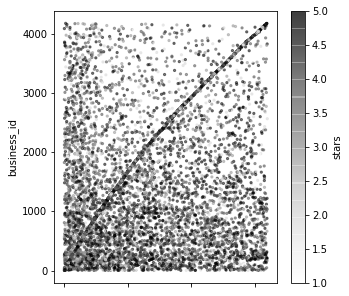

In [88]:
df_train.plot.scatter(x='user_id',y='business_id',c='stars',s=5,figsize=(5,5),alpha=0.5)
plt.xlabel='user_id'
plt.ylabel='business_id'
plt.title='training stars'

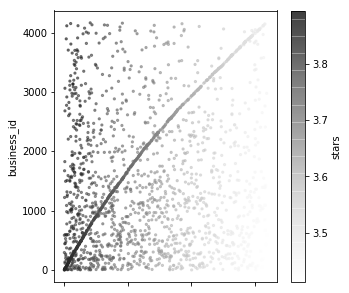

In [87]:
df_test.plot.scatter(x='user_id',y='business_id',c='stars',s=5,figsize=(5,5),alpha=0.5)
plt.xlabel='user_id'
plt.ylabel='business_id'
plt.title='predicted stars'

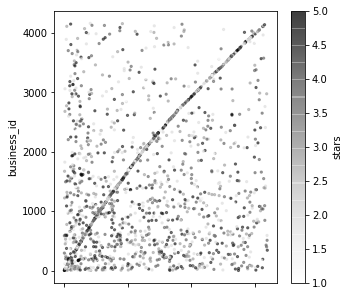

In [82]:
df_sub.plot.scatter(x='user_id',y='business_id',c='stars',s=5,figsize=(5,5),alpha=0.5)
plt.xlabel='user_id'
plt.ylabel='business_id'
plt.title='true stars'

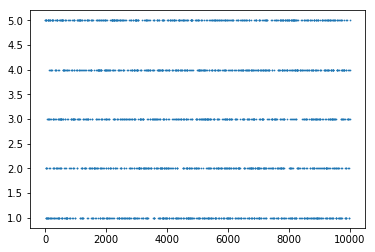

In [47]:
plt.scatter(df_test.review_id,df_sub.stars,s=0.5)
#plt.plot()

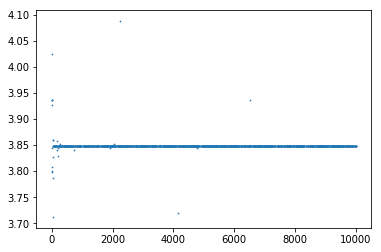

In [93]:
plt.scatter(df_test.review_id,star_pred_svr,s=0.5)